# Sentimental Analysis on Customer Reviews

This notebook digs into customer feedbacks from Amazon Instruments and performs sentimental analysis to understand the issues that customers are facing. Each feedback in the dataset comes with a review message and the rating of product, which scales from 1 to 5. For the purpose of sentimental analysis, the ratings are classified as 

- Negative: score 1 to 2 
- Neutral: score 3 
- Positive: score 4 to 5

This notebook vectorizes customer reviews in 4 different methods:

1. N-grams: use 2 adjacent words as a token
2. TF-IDF
3. word2vec CBOW
4. word2vec Skip-gram

In [1]:
import os
import pandas as pd 

OUTPUT_FOLDER = os.getcwd() + '/output/'

## load raw text
data = pd.read_csv('Musical_instruments_reviews.csv')
data['review'] = (data['summary'] + ' ' + data['reviewText'])
df = pd.DataFrame(data, columns = ['overall', 'review']).dropna().reset_index(drop = True)

## function to map rating scores to sentiment
def get_rating(num):
    if num < 3: 
        return 'negative'
    elif num == 3: 
        return 'neutral'
    else: 
        return 'positive' 

## create new column for sentiment as negative/neutral/positive
df['rating'] = df['overall'].apply(lambda x: get_rating(x))

## create new features: message length
df['length'] = df['review'].apply(lambda x: len(x))

## print raw text
df.head(5)

,overall,review,rating,length
0,5,"good Not much to write about here, but it does...",positive,273
1,5,Jake The product does exactly as it should and...,positive,549
2,5,It Does The Job Well The primary job of this d...,positive,457
3,5,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...,positive,236
4,5,No more pops when I record my vocals. This pop...,positive,197


## Clean Text

- Remove stop words
- Tokenize, convert to lower case and remove punctuation
- Stem tokens using PorterStemmer

In [2]:
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

porter_stemmer = PorterStemmer()

## function to clean raw text
def clean_review(message):

    ### remove stop words
    message_no_stopwrd = remove_stopwords(message)

    ### simple preprocess
    tokens = simple_preprocess(message_no_stopwrd, deacc = True)

    ### stemming tokens
    tokens_stemmed = [porter_stemmer.stem(token) for token in tokens]

    return tokens_stemmed

## print raw text after cleaning 
df_token = df.assign(review = df['review'].apply(lambda x: clean_review(x)))
df_token.head()

,overall,review,rating,length
0,5,"[good, not, write, here, exactli, it, suppos, ...",positive,273
1,5,"[jake, the, product, exactli, afford, realiz, ...",positive,549
2,5,"[it, doe, the, job, well, the, primari, job, d...",positive,457
3,5,"[good, windscreen, for, the, monei, nice, wind...",positive,236
4,5,"[no, pop, record, vocal, thi, pop, filter, gre...",positive,197


## Exploring Data

### (1) Inbalanced distribution of sentiment classes 

This will be addressed in the later section by constructing a new dataset randomly sampling 500 rows with replacement per sentiment class.

positive    9015
neutral      772
negative     467
Name: rating, dtype: int64

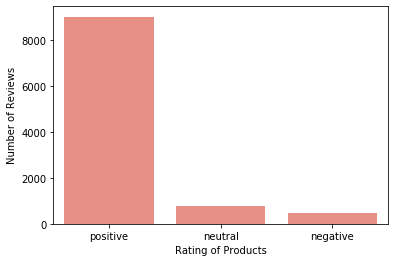

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## plot the distribution of 3-level sentiment
ax = sns.countplot(df_token.rating, color = 'salmon', saturation = 0.7)
ax.set(xlabel = 'Rating of Products', ylabel = 'Number of Reviews')

## print the number of records per sentiment class
df_token['rating'].value_counts()

### (2) Fewer words in positive reviews

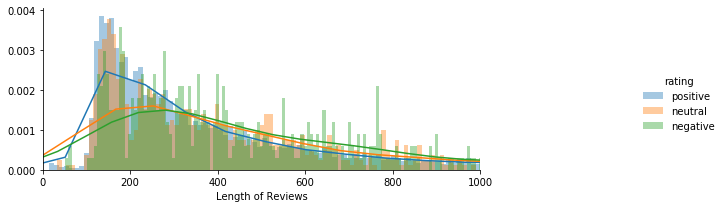

In [4]:
g = sns.FacetGrid(df_token, hue = 'rating')
g = g.set(xlim=(0, 1000))
g.map(sns.distplot, 'length', bins = 1000)
g.add_legend()
g.set(xlabel = 'Length of Reviews', ylabel = '')
g.fig.set_figwidth(12)
g.fig.set_figheight(3)

## Word Cloud


In [5]:
from wordcloud import WordCloud

## function to generate word cloud
def word_cloud_plotter(review_column):
  
    ### generate word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = 'white', 
                    min_font_size = 10).generate(str(review_column)) 
    
    ### plot word cloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.show() 

### (1) Negative Reviews

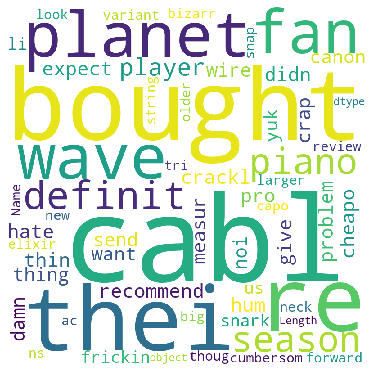

In [6]:
word_cloud_plotter(df_token.query('rating == "negative"').review)

### (2) Positive Reviews

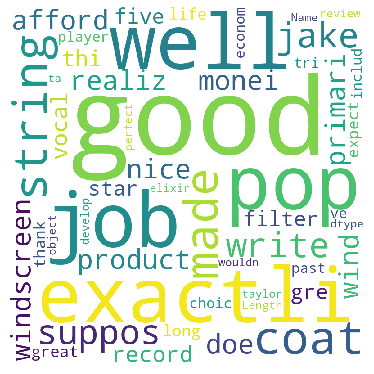

In [7]:
word_cloud_plotter(df_token.query('rating == "positive"').review)

## Word Embeddings

In [8]:
from gensim.models import Word2Vec

## function to train models for work embeddings
def save_wEmbed(model_type, tokens):

    ### set up output folder
    word2vec_model_file = OUTPUT_FOLDER + 'word2vec_' + model_type + '.model'

    ### set up parameters
    size = 1000
    window = 3
    min_count = 1
    workers = 3
    sg = int(model_type == 'sGram')

    ### train model
    w2v_model = Word2Vec(tokens, 
                         min_count = min_count, 
                         size = size, 
                         workers = workers, 
                         window = window, 
                         sg = 1)
    ### save model 
    w2v_model.save(word2vec_model_file)

In [9]:
## extract tokens to fit 
### stemmed_tokens = pd.Series(df_token['review']).values

## save CBOW
### save_wEmbed('CBOW', stemmed_tokens)

## save skip-gram
### save_wEmbed('sGram', stemmed_tokens)

## Vectorize Text
### (1) N-grams (Bigram)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

## counts for bigrams 
ngram_vect = CountVectorizer(ngram_range = (2,2))
X = ngram_vect.fit_transform(' '.join(review) for review in df_token['review'])

## extract N-grams matrix
X_NGrams = pd.DataFrame(X.toarray())
X_NGrams.columns = ngram_vect.get_feature_names()
X_NGrams.head()

,aa aaa,aa adjust,aa batteri,aa cell,aa clip,aa easi,aa think,aaa batteri,aaa etc,aaa hour,...,zt tone,zt updat,zune marketplac,zvex loveped,zwent exot,zylgian damn,zylgian nice,zz top,zzound musician,zzvhgwcolor patch
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### (2) TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = 'word')
X = tfidf_vect.fit_transform(' '.join(review) for review in df_token['review'])

## extract TF-IDF matrix
X_tfidf = pd.DataFrame(X.toarray())
X_tfidf.columns = tfidf_vect.get_feature_names()
X_tfidf.head()

,aa,aaa,aaaand,ab,aback,abalon,abandon,abb,abcd,abehring,...,zone,zoom,zt,zune,zvex,zwent,zylgian,zz,zzound,zzvhgwcolor
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### (3) CBOW and Skip-gram

In [12]:
import numpy as np

## function to write vectorized reviews using work2vec model
def save_X_word2vec(model_type):

    ### set up output filename
    word2vec_filename = OUTPUT_FOLDER + 'X_word2vec_' + model_type + '.csv' 

    ### load word2vec model 
    w2v_model = Word2Vec.load(OUTPUT_FOLDER + 'word2vec_' + model_type + '.model')

    ### write csv file 
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in df_token.iterrows():
            model_vector = (np.mean([w2v_model[token] for token in row['review']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(1000))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(1000)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')

# save_X_word2vec('CBOW')
# save_X_word2vec('sGram')

In [13]:
X_cbow = pd.read_csv(OUTPUT_FOLDER + 'X_word2vec_CBOW.csv')
X_sgram = pd.read_csv(OUTPUT_FOLDER + 'X_word2vec_sGram.csv')

## Small Samples

In [14]:
from numpy import random 

## function to take small samples
def get_samples(size): 
    return np.concatenate(
        [random.choice(df_token.query('rating == "positive"').index, size),
         random.choice(df_token.query('rating == "neutral"').index, size),
         random.choice(df_token.query('rating == "negative"').index, size)
        ],
        axis = 0
    )

## random selection for small samples
# rows_to_take = list(get_samples(500))
rows_to_take = random.choice(range(len(df_token['review'])), 6000)

## split X and y
y_small = df_token.rating[rows_to_take].to_frame()
X_NGrams_small = pd.concat([X_NGrams.iloc[rows_to_take], df_token['length'][rows_to_take]], axis = 1)
X_tfidf_small = pd.concat([X_tfidf.iloc[rows_to_take], df_token['length'][rows_to_take]], axis = 1)
X_cbow_small = pd.concat([X_cbow.iloc[rows_to_take], df_token['length'][rows_to_take]], axis = 1)
X_sgram_small = pd.concat([X_sgram.iloc[rows_to_take], df_token['length'][rows_to_take]], axis = 1)

## Model Selection


### I. Gradient Boosting Machine (GBM)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


## function to calculate cv accuracy 
def get_cv_GBM(X, y, set_seed):
    
    ### set 5-fold cv
    model = GradientBoostingClassifier()
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = set_seed)

    ### print cv accuracy score
    scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

#### (a) GBM on N-grams

In [16]:
# get_cv_GBM(X_NGrams_small, y_small, set_seed = 2020)

#### (b) GBM on TF-IDF

In [17]:
get_cv_GBM(X_tfidf_small, y_small, set_seed = 2020)

Accuracy: 0.894 (0.002)


#### (c) CBOW

In [18]:
get_cv_GBM(X_cbow_small, y_small, set_seed = 2020)

Accuracy: 0.895 (0.007)


#### (d) Skip-gram

In [20]:
# get_cv_GBM(X_sgram_small, y_small, set_seed = 2020)